In [80]:
import librosa
import matplotlib
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from scipy.signal import lfilter
from dataclasses import dataclass

from pymatreader import read_mat
import soundfile as sf

import phast
import abt

@dataclass
class MatlabData:
    M: np.ndarray
    T: np.ndarray
    I_det: np.ndarray
    greenwood_f: np.ndarray
    mat: object = None
    
    pw: float = 18e-6
    
    @staticmethod
    def read(path: str, m: int = 0, scaling_factor: float = 1.1) -> "MatlabData":
        mat = read_mat(path)
        TIa = mat["Df120"]["TIa"][m] * 1e-3
        TIb = mat["Df120"]["TIb"][m] * 1e-3
        I_det = TIa + TIb
        I_det = np.nan_to_num(I_det, nan=np.nanmax(I_det, axis=0))
        
        return MatlabData(
            M = mat['Df120']['M'][m] * scaling_factor,
            T = mat['Df120']['T'][m] * scaling_factor,
            I_det = MatlabData.transform_to_virtual(I_det),
            greenwood_f = np.flip(mat['Df120']['Fn'][m] * 1e3),
            mat=mat
        )
        
        
    @staticmethod
    def transform_to_virtual(i_det):
        reshaped = i_det[:, :i_det.shape[1] - 1, :].reshape(-1, i_det.shape[2]).T
        return np.flip(np.c_[reshaped, i_det[-1, -1, :]], axis=0)
    
    @property
    def i_det(self):
        'i_det no cs'
        return self.I_det[:, 4::8]
    
    def spatial_factor(self, fiber_idx, i_det):
        return np.nanmin(i_det, axis=0) / i_det[fiber_idx, :]

    def sigma(self, fiber_idx, i_det):
        return i_det[fiber_idx, :] * 0.06
   

def create_neurogram(fiber_stats, selected_fibers, binsize, duration):
    bins = np.arange(0, duration, binsize)
    data = np.zeros((len(selected_fibers), len(bins)))
    for i, fiber_idx in enumerate(selected_fibers):
        fs = [fs for fs in fiber_stats if fs.fiber_id == fiber_idx]
        spike_times = phast.spike_times(fs)
        idx = np.digitize(spike_times, bins)
        values, counts = np.unique_counts(idx)
        data[i, values] += counts
    return data

25.8188
(20, 243)
(121, 49530)
<PulseTrain n_pulses: 18558 duration : 0.891540> 0.89154


array([3.19641092, 3.01421362, 2.85071032, 2.61320866, 2.39823433,
       2.6858498 , 3.00015195, 3.20895918, 3.39897842, 3.28973725,
       3.26084224, 3.20863981, 2.91871291, 2.02124967, 2.18121324,
       2.27680696, 2.47901875, 2.38638423, 2.26241609, 2.1856572 ,
       2.10793299, 2.22174191, 2.38213271, 2.54774661, 2.69451168,
       2.54862173, 2.38252124, 2.38035716, 2.44634309, 2.13291875,
       2.0366583 , 2.4845681 , 2.82013416, 2.6640808 , 2.62495529,
       2.50831   , 2.50138023, 2.65367968, 2.75886441, 2.65843496,
       2.88115289, 2.03681115, 2.40336017, 1.83724234, 1.94719552,
       2.1400742 , 2.33458942, 2.51790922, 2.75997599, 2.77057299,
       2.65476584, 2.48071888, 2.04337371, 2.26283288, 2.4489072 ,
       2.68117117, 2.93226974, 2.20495945, 2.97947422, 2.71850765,
       2.40928814, 2.9367405 , 3.16232702, 3.29858781, 3.08820125,
       2.87537722, 2.77465935, 2.75556408, 2.7997024 , 2.78561779,
       2.85108968, 2.80710186, 3.16536115, 2.7846541 , 2.77706

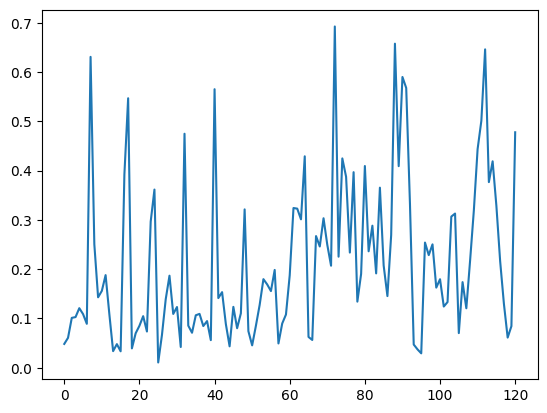

In [81]:
MIN_FREQ = 150
MAX_FREQ = 8000

FS = 17400
NAME = "defineit"
N_MELS = 20
N_FFT = 2048
N_HOP = N_FFT // 32
CS = True

MEL_SCALE = librosa.filters.mel_frequencies(N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ) 

MAT = MatlabData.read("Fidelity120 HC3A MS All Morphologies 18us CF.mat", scaling_factor=1)

IDET = MAT.i_det if not CS else MAT.I_det

pulse_train, audio_signal = abt.wav_to_electrodogram(
    abt.sounds[NAME], 
    current_steering=CS, 
    charge_balanced=False,  
    virtual_channels=True,
    apply_audiomixer=False,
    ramp_type = 'cs',
    # M=MAT.M * 1000,
    # T=MAT.T * 1000,
    Fs = FS,
    stim_db = 67,
    ramp_duration=0.1
)

audio_signal = audio_signal[0]

S = librosa.feature.melspectrogram(y=audio_signal, sr=FS, n_fft=N_FFT, hop_length=N_HOP, n_mels=N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ)
ref_db = np.max(S)

print(ref_db)
print(S.shape)

stimulus = phast.PulseTrain(pulse_train, time_step=MAT.pw)
duration = stimulus.t_max * MAT.pw
print(pulse_train.shape)
print(stimulus, duration)

# np.abs(pulse_train.max(axis=1)) / IDET.min(axis=0)

# pulse_train = pulse_train / IDET.min(axis=0).reshape(-1, 1)

# pt = pulse_train.copy()
# pt[pt == 0 ] = 100

# scaler = (IDET.min(axis=0) / (pulse_train.max(axis=1) - np.min(pt, axis=1))).reshape(-1, 1)
# pulse_train *= scaler


pulse_train *= 5
plt.plot(pulse_train.sum(axis=1))
pulse_train.max(axis=1) / IDET.min(axis=0)



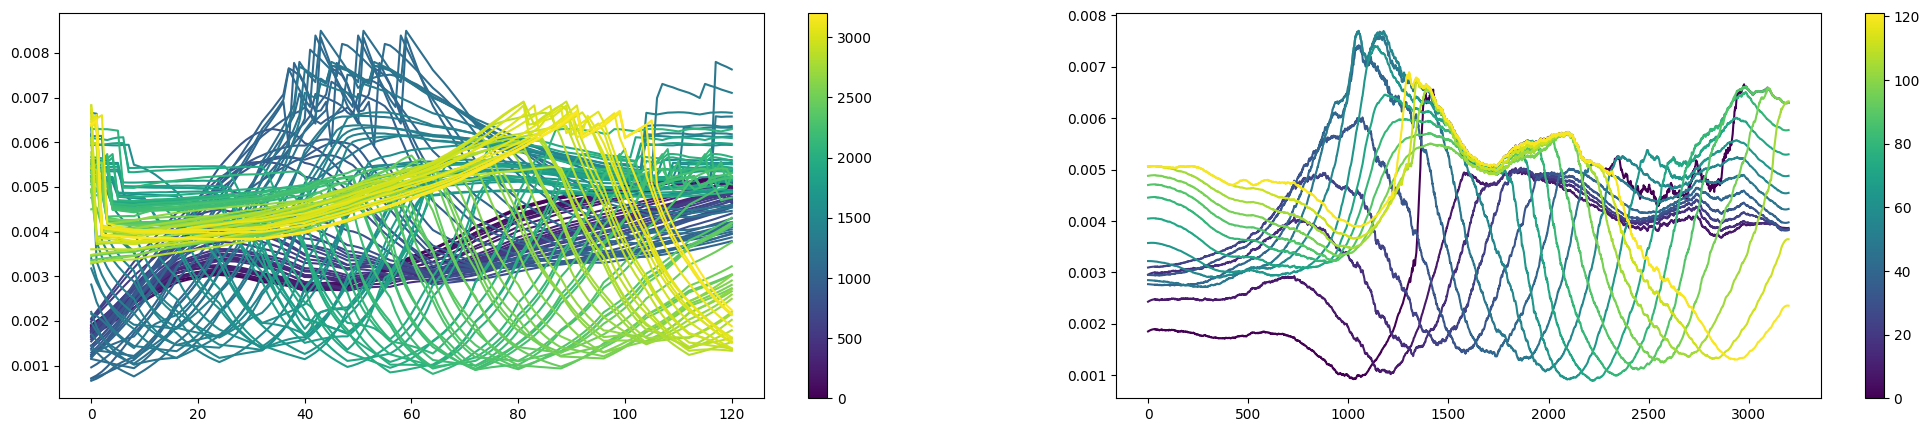

In [82]:
class Colorizer:
    def __init__(self, vmin=0, vmax=1, cmap_name = 'viridis'):
        cmap = plt.get_cmap(cmap_name)
        import matplotlib.colors as mcolors
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        self.scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        
    def __call__(self, value):
        return self.scalar_map.to_rgba(value)

def filt(x):
    return scipy.signal.savgol_filter(x, 64, 2) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 5))
c = Colorizer(vmax=3200)
for fiber in range(0, 3200, 25):
    ax1.plot(MAT.I_det[fiber, :], color=c(fiber))

fig.colorbar(c.scalar_map, ax=ax1)    
c = Colorizer(vmax=121)
for e in range(0, 121, 8):
    ax2.plot(filt(MAT.I_det[:, e]), color=c(e))
fig.colorbar(c.scalar_map, ax=ax2);




AssertionError: 

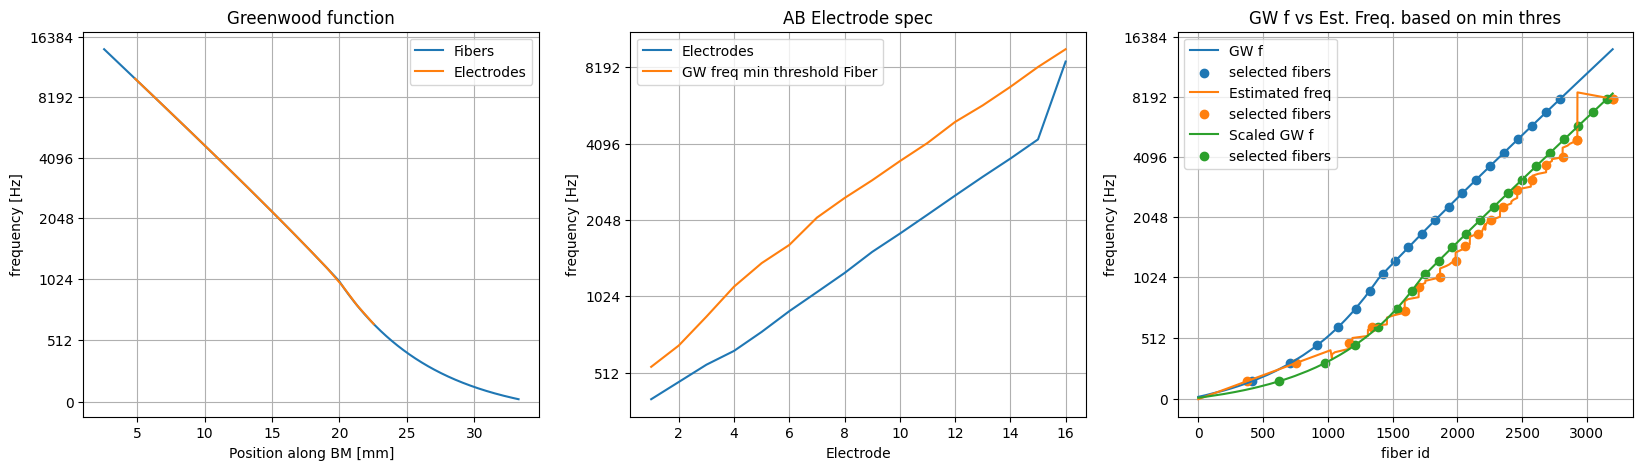

In [92]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(MAT.mat['Df120']['Ln'][0], MAT.mat['Df120']['Fn'][0] * 1e3, label="Fibers")
ax1.plot(MAT.mat['Df120']['Le'][0], MAT.mat['Df120']['Fe'][0] * 1e3, label="Electrodes")
ax1.set_xlabel("Position along BM [mm]")
abt.utils.frequency_ax(ax1)
ax1.legend()
ax1.grid()
ax1.set_title("Greenwood function")

electrodes = np.arange(1, 17)
gwf_min_thresh = MAT.greenwood_f[np.argmin(MAT.I_det[:,::8], axis=0)]

ax2.plot(electrodes, abt.utils.virtual_channel_frequencies(16), label="Electrodes")
ax2.plot(electrodes, gwf_min_thresh, label="GW freq min threshold Fiber")

ax2.legend()
ax2.grid()
ax2.set_title("AB Electrode spec")
ax2.set_xlabel("Electrode")
abt.utils.frequency_ax(ax2)


# # Remapping selected fibers
min_thresh_fiber_idx = np.argmin(MAT.I_det[:,:], axis=0)

f = scipy.interpolate.interp1d(
    np.r_[0, min_thresh_fiber_idx, 3200], 
    np.r_[0, abt.utils.virtual_channel_frequencies(121), MAX_FREQ], 
    fill_value='extrapolate'
)

fidx = np.arange(0, 3200)
int_freq = f(fidx)

# ax2.plot(fidx, int_freq)

gwf = MAT.greenwood_f.copy()
gwf_scaled = gwf * .6

selected_fibers_gw = np.array([abt.utils.find_nearest_idx(gwf, val) for val in MEL_SCALE])
selected_fibers_gw_scaled = np.array([abt.utils.find_nearest_idx(gwf_scaled, val) for val in MEL_SCALE])
selected_fibers_est = np.array([abt.utils.find_nearest_idx(int_freq, val) for val in MEL_SCALE])

p = ax3.plot(fidx, gwf, label="GW f")
ax3.scatter(selected_fibers_gw, gwf[selected_fibers_gw], color=p[0].get_color(), label='selected fibers')
p = ax3.plot(fidx, f(fidx), label="Estimated freq")
ax3.scatter(selected_fibers_est, int_freq[selected_fibers_est], color=p[0].get_color(), label='selected fibers')

p = ax3.plot(fidx, gwf_scaled, label="Scaled GW f")
ax3.scatter(selected_fibers_gw_scaled, gwf_scaled[selected_fibers_gw_scaled], color=p[0].get_color(), label='selected fibers')


ax3.legend()
ax3.set_xlabel("fiber id")
abt.utils.frequency_ax(ax3)
ax3.grid()
ax3.set_title("GW f vs Est. Freq. based on min thres");

# # Using estimated fibers
selected_fibers = selected_fibers_est
selected_fibers_freq = int_freq[selected_fibers]

# # Using scaled Gw function
# selected_fibers = selected_fibers_gw_scaled
# selected_fibers_freq =  gwf_scaled[selected_fibers]

# # Using original Gw function
# # selected_fibers = selected_fibers_gw
# # selected_fibers_freq =  gwf[selected_fibers]

assert np.unique(selected_fibers).size == selected_fibers.size



In [112]:
# f = scipy.interpolate.interp1d(
#     np.r_[0, min_thresh_fiber_idx], 
#     np.r_[0, abt.utils.virtual_channel_frequencies(121)], 
#     kind="quadratic",
#     fill_value='extrapolate'
# )

# fidx = np.arange(0, 3200)
# int_freq = f(fidx)

# plt.plot(int_freq)


np.unique(min_thresh_fiber_idx, return_counts=True)

# idx = np.array([abt.utils.find_nearest_idx(int_freq, val) for val in MEL_SCALE])
# plt.plot(idx, MEL_SCALE)


(array([1021, 1032, 1053, 1163, 1189, 1309, 1340, 1359, 1456, 1502, 1570,
        1593, 1617, 1701, 1719, 1752, 1822, 1866, 1905, 1935, 1952, 1986,
        2024, 2056, 2096, 2134, 2172, 2190, 2214, 2215, 2231, 2256, 2297,
        2329, 2344, 2381, 2416, 2432, 2462, 2498, 2567, 2579, 2618, 2685,
        2705, 2730, 2812, 2849, 2865, 2895, 2926]),
 array([1, 3, 1, 5, 3, 5, 2, 1, 6, 1, 1, 6, 1, 6, 1, 2, 1, 6, 1, 1, 1, 5,
        1, 2, 5, 1, 1, 1, 1, 3, 1, 1, 1, 4, 2, 1, 2, 1, 5, 1, 4, 3, 1, 5,
        1, 2, 6, 1, 1, 1, 2]))

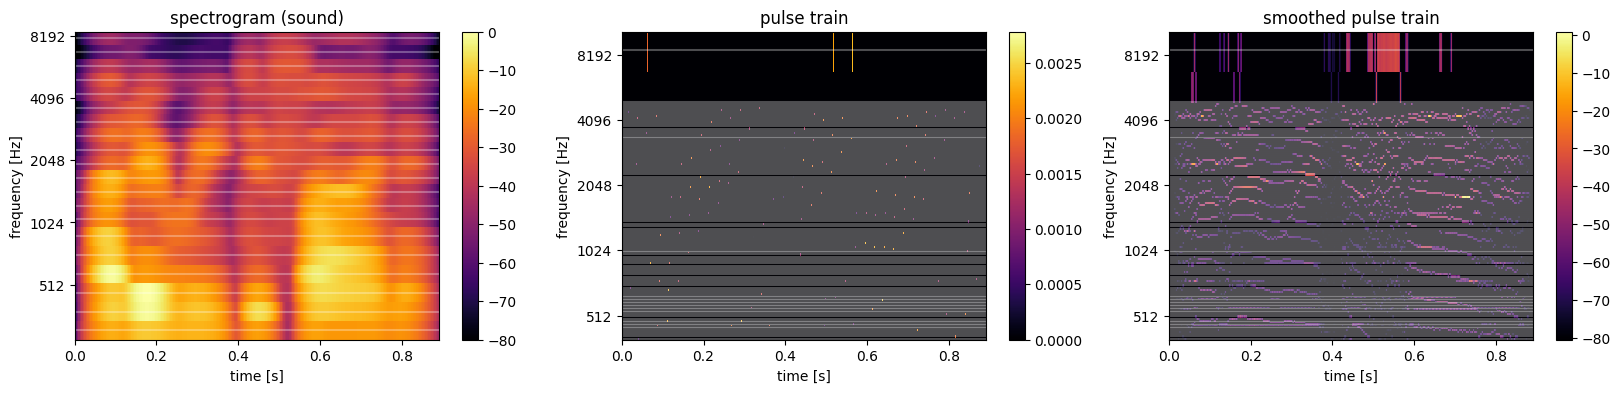

In [84]:
pdata = np.abs(pulse_train)
pdata = abt.utils.apply_filter(pdata, window_size=256, resample_to=pdata.shape[1], scale=True)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

S_db = librosa.power_to_db(S, ref=np.max)
ts = np.linspace(0, duration, len(S_db[0]))

abt.utils.plot_heatmap(ts, MEL_SCALE, S_db, ax1, f, pad_idx=False)
ax1.set_title("spectrogram (sound)")

abt.utils.plot_heatmap(
    np.arange(pulse_train.shape[1]) * MAT.pw,
    abt.utils.virtual_channel_frequencies(pulse_train.shape[0]),
    np.abs(pulse_train),
    ax=ax2,
    fig=f
)

ax2.set_title("pulse train")
abt.utils.plot_heatmap(
    np.arange(pulse_train.shape[1]) * MAT.pw,
    abt.utils.virtual_channel_frequencies(pulse_train.shape[0]),
    pdata,
    ax=ax3,
    fig=f
)
ax3.set_title("smoothed pulse train");

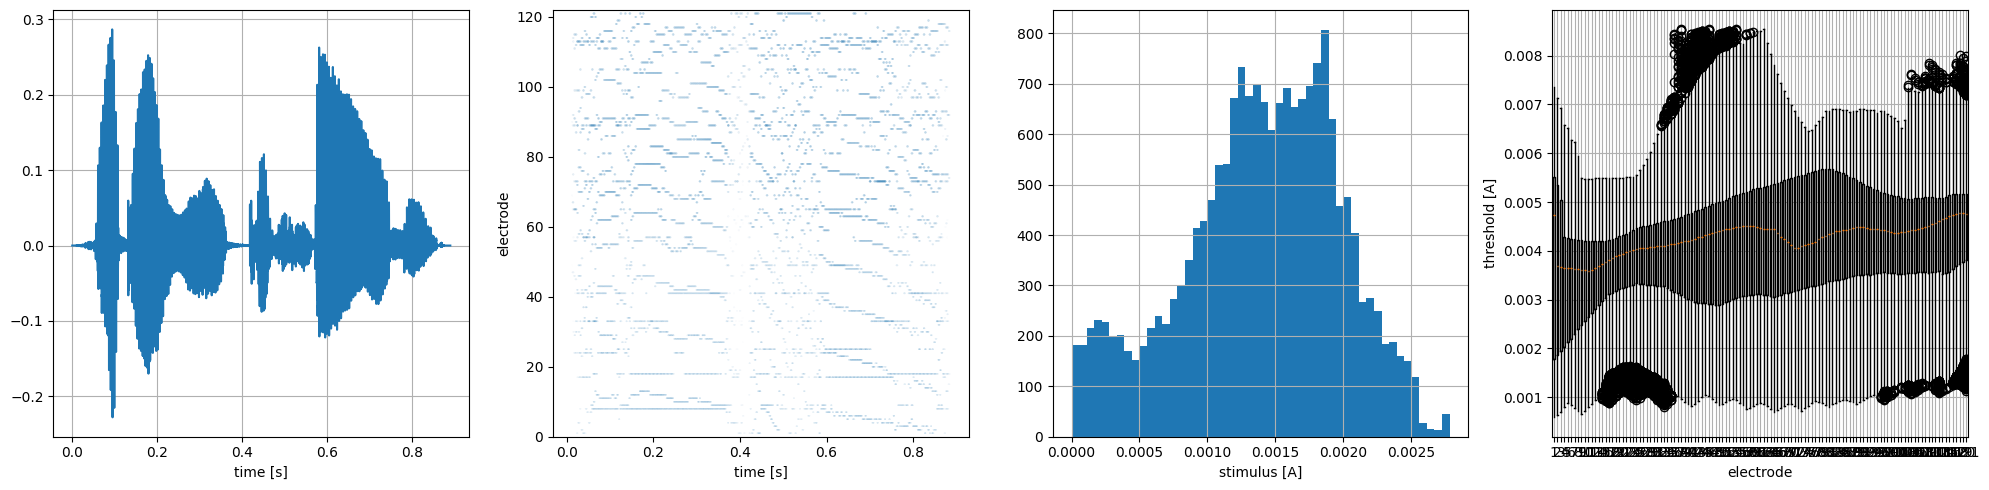

In [85]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(20, 5))

t_audio = np.arange(len(audio_signal)) * 1 / FS
ax1.plot(t_audio, audio_signal)
ax1.set_xlabel("time [s]")
ax1.grid()

e, t = np.where((pulse_train) > 0)
ax2.scatter(t * MAT.pw, e + 1, s=np.abs(pulse_train[e, t]))
ax2.set_ylim(1, pulse_train.shape[0])
ax2.set_xlabel("time [s]")
ax2.set_ylabel("electrode")
ax2.set_ylim(0, pulse_train.shape[0] + 1)

ax3.hist(np.abs(pulse_train[pulse_train > 0]), bins=50)
ax3.set_xlabel("stimulus [A]")
ax3.grid()

ax4.boxplot(IDET)
ax4.set_ylabel("threshold [A]")
ax4.set_xlabel("electrode")
ax4.grid()

plt.tight_layout()


(0.0, 8000.0)

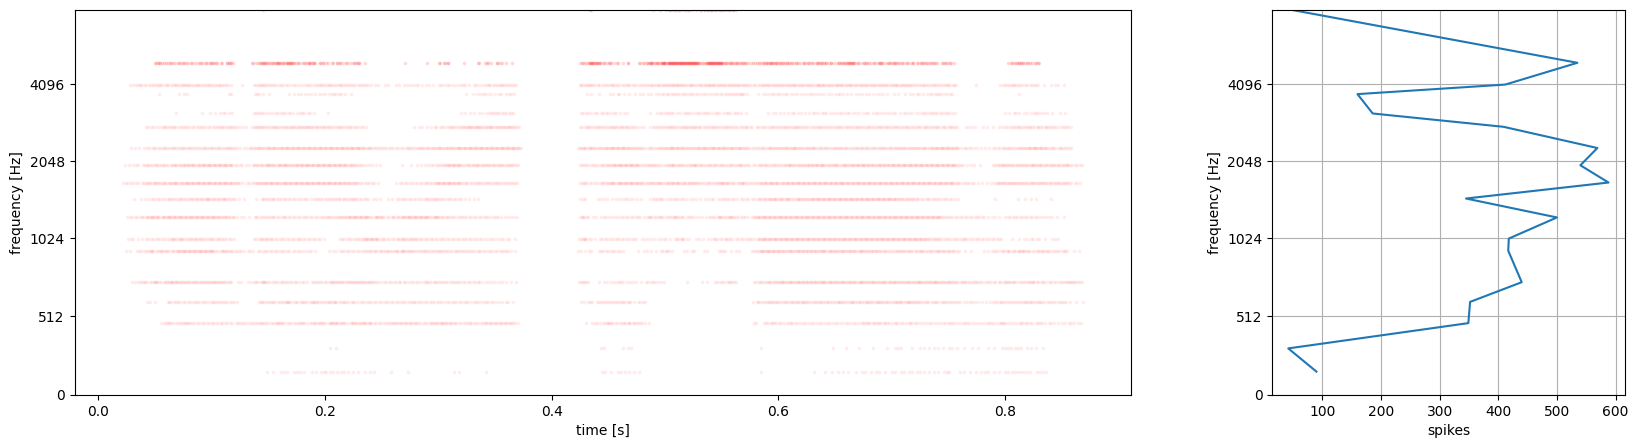

In [86]:
stimulus = phast.PulseTrain(pulse_train, time_step=MAT.pw)

decay = phast.LeakyIntegratorDecay(
    accommodation_amplitude=0.072,
    adaptation_amplitude=7.142,
    accommodation_rate=0.014,
    adaptation_rate=19.996
)

fibers = []
for fiber_idx in selected_fibers:
    fibers.append(
        phast.Fiber(
            i_det=IDET[fiber_idx],
            # spatial_constant=np.ones(IDET.shape[0]), 
            spatial_constant=MAT.spatial_factor(fiber_idx, IDET) * .1,
            sigma=MAT.sigma(fiber_idx, IDET),  
            fiber_id=fiber_idx,
            n_max=stimulus.n_pulses,  
            decay=decay,  
            store_stats=False,
        )
    )
    

fiber_stats = phast.phast(fibers, stimulus, generate_trials = 1, evaluate_in_parallel=True)

duration = stimulus.time_step * stimulus.t_max
binsize = 1e-5

neurogram = create_neurogram(fiber_stats, selected_fibers, binsize, duration)
del fiber_stats
import gc;gc.collect()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), width_ratios=[3, 1])
for y in range(len(selected_fibers)):
    x = np.where(neurogram[y, :])[0]
    y = selected_fibers_freq[y]
    ax1.scatter(x * binsize, y * np.ones(len(x)), color="red", alpha=.05, s=3)
    
ax2.plot(neurogram.sum(axis=1), selected_fibers_freq)
ax2.grid()
ax2.set_xlabel("spikes")
abt.utils.frequency_ax(ax2)
abt.utils.time_vs_freq(ax1)
ax2.set_ylim(0, MAX_FREQ)
ax1.set_ylim(0, MAX_FREQ)



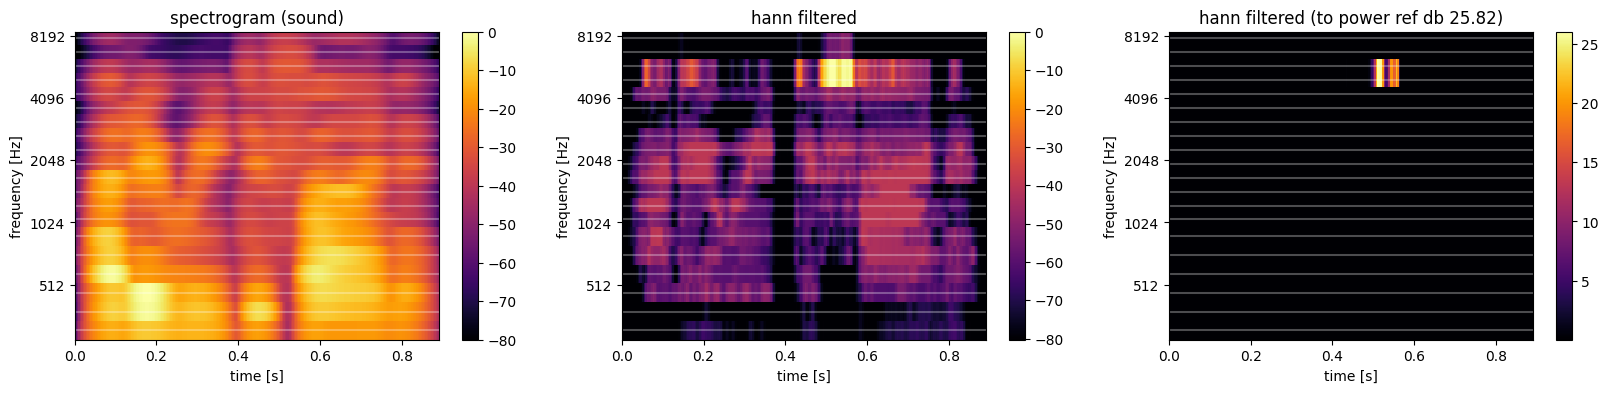

In [87]:
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 4))

abt.utils.plot_heatmap(ts, MEL_SCALE, S_db, ax0, f)
ax0.set_title("spectrogram (sound)")

filtered_data = abt.utils.apply_filter(neurogram, resample_to=S.shape[1])

t = np.linspace(0, duration, len(filtered_data[0]))
abt.utils.plot_heatmap(t, MEL_SCALE, filtered_data, ax=ax1, fig=f)
ax1.set_title("hann filtered")

ref_db = np.max(S)
mel_spec_ng = librosa.db_to_power(filtered_data, ref=ref_db)
abt.utils.plot_heatmap(t, MEL_SCALE, mel_spec_ng, ax=ax2, fig=f)
ax2.set_title(f"hann filtered (to power ref db {ref_db:.2f})");


In [88]:
mel_inversed = librosa.feature.inverse.mel_to_audio(mel_spec_ng,  n_fft=N_FFT, hop_length=N_HOP, sr=FS, fmin=MIN_FREQ, fmax=MAX_FREQ)

mel_inversed = scipy.signal.resample(mel_inversed, audio_signal.size)

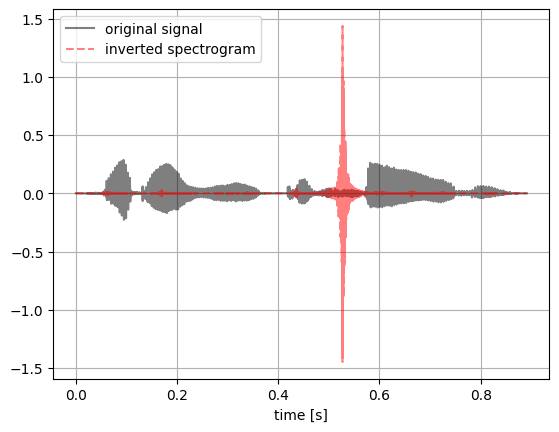

In [89]:
sc = (audio_signal.max() - audio_signal.min()) / (mel_inversed.max() - mel_inversed.min())
# mel_inversed *= sc

t_audio = np.arange(len(audio_signal)) * 1 / FS
plt.plot(t_audio, audio_signal, label="original signal", color="black", alpha=.5)
plt.xlabel("time [s]")

t_mel = np.arange(len(mel_inversed)) * 1 / FS

plt.plot(
    t_mel, 
    mel_inversed,
    label="inverted spectrogram", 
    color ="red", 
    linestyle="dashed", 
    alpha=.5
)

mel_filt = scipy.signal.savgol_filter(mel_inversed, 64, 2) 
mel_filt *= (audio_signal.max() - audio_signal.min()) / (mel_filt.max() - mel_filt.min())

# plt.plot(
#     t_mel, mel_filt,
#     label="inverted spectrogram (filtered)", color ="blue", linestyle="dashed", alpha=.5
# )
plt.grid()
plt.legend()

sf.write(
    f"output/{NAME}.wav", audio_signal, FS, subtype='PCM_24'
)

# sf.write(
#     f"output/mel_reconstructed_{NAME}_filt.wav", mel_filt, FS, subtype='PCM_24'
# )

sf.write(
    f"output/mel_reconstructed_{NAME}_ci.wav", mel_inversed, FS, subtype='PCM_24'
)


# n = int(np.ceil(mel_inversed.size * (16000 / FS)))
# mp3 = scipy.signal.resample(mel_inversed, n)
# sf.write(
#         f"output/mel_reconstructed_{NAME}_ci.mp3", mp3, 16000,
#         format='MP3', subtype='MPEG_LAYER_III'
# )




In [90]:
mel_inversed.size, audio_signal.size



(15507, 15507)

In [91]:
FS

17400